In [1]:
import copy
import shap
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
from copy import deepcopy
from scipy.stats import rankdata
import matplotlib.gridspec as gridspec

import sys
sys.path.append('../scripts/')
from utils import *
from config import *
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.colors
import seaborn as sns

mlp.rcParams['lines.linewidth'] = 2
mlp.rcParams['axes.grid'] = True
mlp.rcParams['grid.linestyle'] = '--'
mlp.rcParams['xtick.labelsize'] = 12
mlp.rcParams['ytick.labelsize'] = 12
mlp.rcParams['axes.labelsize'] = 14
mlp.rcParams['legend.fontsize'] = 12
mlp.rcParams['font.size'] = 12
mlp.rcParams['font.family'] = 'serif'
mlp.rcParams['mathtext.fontset'] = 'dejavuserif'

## Load data

In [2]:
with open('../data/comb.pickle', 'rb') as handle:
    data = pickle.load(handle)

df, metadata, features, target, rows = data.values()

In [3]:
features = ['BCUT2D_MRHI','AXp-6dv','piPC4','GATS1d','Kappa3','AATS7i','AATS8i','GATS2v','MATS1v','GATS2m','MATS2s','MATS2d','GATS3dv','GATS4dv',
            'ATSC5c','ATSC5d','GATS6s','ATSC7dv','MPC5','BCUTi-1h','fr_Ndealkylation1','MINssO','MDEC-13','PEOE_VSA8','MINdO','BCUTdv-1l','fr_NH0',
            'naHRing','SlogP_VSA10']

In [4]:
train = df.loc[rows,features+[target]].copy()
train.reset_index(drop=True, inplace=True)
train[target].replace({'Bitter': 0, 'Sweet': 1}, inplace=True)
custom_cv = create_folds(train=train, features=features, target=target, num_folds=NUM_FOLDS, shuffle=True, seed=SEED)

## Computing SHAP values in cross-validation

In [5]:
PARAMS_GB_ = {i:PARAMS_GB[i] for i in PARAMS_GB if i not in ['early_stopping_round', 'num_iterations']}

In [7]:
NUM_REPEATS = 5
NUM_FOLDS = 5

oof_preds_list = []
oof_shap_values_list = []
#oof_shap_preds_list = []
results_list = []
models = []
explainers = []
columns = ['valid_' + metric for metric in PARAMS_GB['metric']] if isinstance(PARAMS_GB['metric'], list) else ['valid_' + PARAMS_GB['metric']]
train_lgb = lgb.Dataset(train[features], train[target], feature_name=features, free_raw_data=False)
callbacks = [lgb.log_evaluation(period=-1, show_stdv=True), lgb.early_stopping(stopping_rounds=PARAMS_GB['early_stopping_round'], first_metric_only=False, verbose=True)]

for i in range(NUM_REPEATS):
    
    oof_preds = np.zeros(train.shape[0])
    oof_shap_values = np.zeros((train.shape[0], len(features)))
    #oof_shap_preds = np.zeros(train.shape[0])
    results = pd.DataFrame(index=range(len(custom_cv)), columns=['fold'] + columns)
    custom_cv = create_folds(train=train, features=features, target=target, num_folds=NUM_FOLDS, shuffle=True, seed=SEED*i)
    
    cv_results = lgb.cv(params=PARAMS_GB,
                        train_set=train_lgb,
                        folds=custom_cv,
                        metrics=PARAMS_GB['metric'],
                        num_boost_round=PARAMS_GB['num_iterations'],
                        stratified=False,
                        callbacks=callbacks,
                        eval_train_metric=True,
                        return_cvbooster=True)
    best_iteration = cv_results['cvbooster'].best_iteration
    print(best_iteration)
    
    for n_fold, (train_fold_idx, valid_fold_idx) in enumerate(custom_cv):
        train_fold = train.loc[train_fold_idx].copy()
        valid_fold = train.loc[valid_fold_idx].copy()
        train_fold_lgb = lgb.Dataset(train_fold[features], train_fold[target], reference=train_lgb)
        valid_fold_lgb = lgb.Dataset(valid_fold[features], valid_fold[target], reference=train_lgb)
        model = lgb.train(PARAMS_GB_, train_fold_lgb, num_boost_round=best_iteration)
        models.append(model)
        oof_preds[valid_fold_idx] = model.predict(valid_fold[features], num_iteration=best_iteration)
        explainer = shap.TreeExplainer(model, data=train_fold[features], feature_perturbation='interventional', model_output='probability')
        explainers.append(explainer)
        oof_shap_values[valid_fold_idx] = explainer.shap_values(valid_fold[features], check_additivity=True)
        #oof_shap_preds[valid_fold_idx] = oof_shap_values[valid_fold_idx].sum(axis=1) + explainer.expected_value
        
        results.loc[n_fold, 'fold'] = n_fold+1
        results.loc[n_fold, 'valid_auc'] = roc_auc_score(valid_fold[target], oof_preds[valid_fold_idx])
        print('Fold {fold} AUC: {auc:.5f}'.format(fold=n_fold+1, auc=results.loc[n_fold, 'valid_auc']))
        
    #print(np.mean(np.abs(oof_shap_preds-oof_preds)))
    
    print('Folds AUC: {avg_auc:.5f}+-{std_auc:.5f}'.format(avg_auc=results['valid_auc'].mean(), std_auc=results['valid_auc'].std(ddof=0)))
    print('Total AUC: {auc:.5f}'.format(auc=roc_auc_score(train[target], oof_preds)))
    
    oof_preds_list.append(oof_preds)
    oof_shap_values_list.append(oof_shap_values)
    #oof_shap_preds_list.append(oof_shap_preds)
    results_list.append(results)

d = {'models': models, 'explainers': explainers}

with open('../models/models.pickle', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[178]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.943465 + 0.00808939
178
Fold 1 AUC: 0.95201
Fold 2 AUC: 0.94324
Fold 3 AUC: 0.94984
Fold 4 AUC: 0.94337
Fold 5 AUC: 0.92885
Folds AUC: 0.94346+-0.00809
Total AUC: 0.94289
Early stopping, best iteration is:
[178]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.943664 + 0.00463704
178
Fold 1 AUC: 0.94383
Fold 2 AUC: 0.94880
Fold 3 AUC: 0.93609
Fold 4 AUC: 0.94805
Fold 5 AUC: 0.94154
Folds AUC: 0.94366+-0.00464
Total AUC: 0.94290
98
Fold 1 AUC: 0.94041
Fold 2 AUC: 0.95213
Fold 3 AUC: 0.93915
Fold 4 AUC: 0.92844
Fold 5 AUC: 0.94190
Folds AUC: 0.94041+-0.00754
Total AUC: 0.94008
140
Fold 1 AUC: 0.94577
Fold 2 AUC: 0.96422
Fold 3 AUC: 0.91735
Fold 4 AUC: 0.93416
Fold 5 AUC: 0.95573
Folds AUC: 0.94345+-0.01646
Total AUC: 0.94255
91
Fold 1 AUC: 0.93831
Fold 2 AUC: 0.93943
Fold 3 AUC: 0.92652
Fold 4 AUC: 0.95323
Fold 

In [8]:
## Load models and explainers
with open('../models/models.pickle', 'rb') as handle:
    models_explainers = pickle.load(handle)
models, explainers = models_explainers.values()

In [9]:
shap_values = shap.Explanation(values=np.mean(oof_shap_values_list, axis=0),
                               base_values=np.tile(np.mean(oof_preds_list), train.shape[0]),
                               data=train[features].values,
                               feature_names=features
                              )

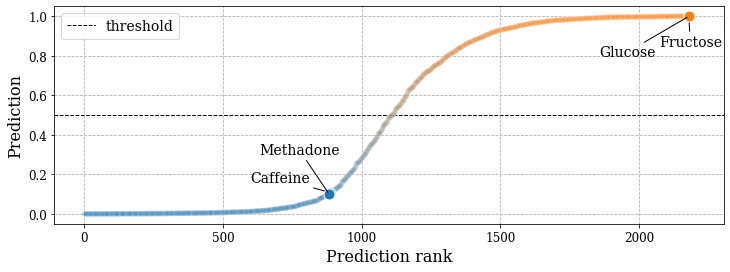

In [10]:
molecules = {
            #1893: 'Sucrose',
             1796:'Fructose',
             1799:'Glucose',
             105:'Caffeine',
             134:'Methadone',
             #157:'Propanolol'
}

norm=plt.Normalize(-2,2)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["tab:blue","tab:orange"])

fig = plt.figure(figsize=(12,4))
y = np.mean(oof_preds_list, axis=0)
x = rankdata(y)
plt.scatter(x,y, alpha=0.1,
            c=y,
            cmap=cmap,
            edgecolors='w', s=30, zorder=2)

offsetsx = [-30,-90,-120,-70,-70,40]
offsetsy = [-30,-40,-20,10,40,30]
offsetsx = [-30,-90,-80,-70]
offsetsy = [-30,-40,10,40]
for i, (idx, name) in enumerate(molecules.items()):
    y_ = np.minimum(shap_values[idx].values.sum()+shap_values[idx].base_values, 0.9995)
    x_ = np.where(np.sort(y) > y_)[0][0]
    if y_ < 0.5:
        plt.scatter(x_, y_, color='tab:blue', zorder=3, s=120, edgecolors='w')
        plt.annotate(name, xy=(x_, y_), xycoords='data', xytext=(offsetsx[i], offsetsy[i]), textcoords='offset points', arrowprops=dict(arrowstyle="-"), 
                    fontsize=14)
    else:
        plt.scatter(x_, y_, color='tab:orange', zorder=3, s=120, edgecolors='w')
        plt.annotate(name, xy=(x_, y_), xycoords='data', xytext=(offsetsx[i], offsetsy[i]), textcoords='offset points', arrowprops=dict(arrowstyle="-"), 
                    fontsize=14)
    plt.xlabel('Prediction rank', fontsize=16)
    plt.ylabel('Prediction', fontsize=16)
plt.axhline(0.5, linestyle='--', color='k', linewidth=1, label='threshold', zorder=0)
plt.legend(fontsize=14);
#fig.savefig(os.path.join('..', 'images', 'Predictions.png'), dpi=fig.dpi, bbox_inches='tight')

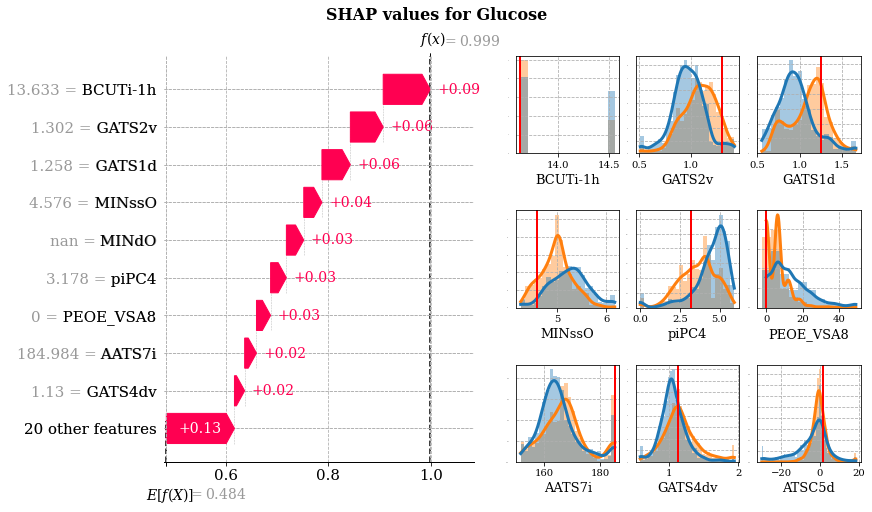

In [11]:
molecules = {1893: 'Sucrose', 1796:'Fructose', 1799:'Glucose', 105:'Caffeine', 134:'Methadone', 157:'Propanolol'}

FEATS_TO_DISPLAY = 10
SAMPLE = 1799

shap_values_tmp = deepcopy(shap_values[SAMPLE])

if shap_values_tmp.values.sum()+shap_values_tmp.base_values > 1:
    d1 = 0.999 - shap_values_tmp.base_values
    d2 = d1/shap_values_tmp.values.sum()
    shap_values_tmp.values = d2*shap_values_tmp.values

fig = plt.figure(constrained_layout=True)

gs = gridspec.GridSpec(3, 6, figure=fig)

##########
ax2 = plt.subplot(gs[0:3, 0:3])
plt.sca(ax2) # set current axis
ax2.grid(zorder=0)
#shap.plots.waterfall(shap_values_tmp, max_display=FEATS_TO_DISPLAY, show=False)
shap_waterfall(shap_values_tmp, max_display=FEATS_TO_DISPLAY, show=False)
fig.set_size_inches(12,7)

##########
indices = list(itertools.product([0,1,2], [3,4,5]))
tmp = pd.DataFrame({'shap_values': shap_values[SAMPLE].values,
                    'data': shap_values[SAMPLE].data,
                    'abs_shap_values': np.abs(shap_values[SAMPLE].values)},
                    index=shap_values[SAMPLE].feature_names).dropna().sort_values('abs_shap_values', ascending=False).iloc[:9]
feats = tmp.index.tolist()
datas = tmp.data.values
axes = []

for idx,col,dat in zip(indices, feats, datas):
    ax = plt.subplot(gs[idx])
    axes.append(ax)
    train_tmp = train.copy()
    if col == 'BCUTi-1h':
        train_tmp = train.dropna(subset=[col]).copy()
        train_tmp[col] = train_tmp[col].clip(train_tmp[col].quantile(0.01), train_tmp[col].quantile(0.99))
        bins = find_bins(train_tmp[col].values, 1)
        train_tmp['bins'] = pd.cut(train_tmp[col], bins=bins, include_lowest=True)
        train_tmp_grouped = train_tmp.groupby('bins', as_index=False)[col].mean()
        train_tmp = pd.merge(train_tmp, train_tmp_grouped, how='left', on='bins', suffixes=(None, '_binned'))
        sns.histplot(data=train_tmp, x=col+'_binned', hue=target, kde=False, stat='density', edgecolor='white', linewidth=0, alpha=0.4, line_kws=dict(linewidth=3), legend=False)
        ax.set_xlabel(col)
    elif col == 'fr_NH0':
        train_tmp = train.dropna(subset=[col]).copy()
        minx, maxx = train_tmp[col].min(), train_tmp[col].max()
        sns.histplot(data=train_tmp, x=col, hue=target, kde=False, stat='density', edgecolor='white', linewidth=0, alpha=0.4, line_kws=dict(linewidth=3), bins=np.arange(minx-0.25, maxx+0.25, 0.5), legend=False)
    elif col in ['PEOE_VSA8', 'MPC5']:
        dic = {'PEOE_VSA8':5, 'MPC5':10}
        train_tmp = train.dropna(subset=[col]).copy()
        train_tmp[col] = train_tmp[col].clip(train_tmp[col].quantile(0.01), train_tmp[col].quantile(0.99))
        minx, maxx = train_tmp[col].min(), train_tmp[col].max()
        d = dic[col]
        sns.histplot(data=train_tmp, x=col, hue=target, kde=True, stat='density', edgecolor='white', linewidth=0, alpha=0.4, line_kws=dict(linewidth=3), bins=np.arange(minx-d/2, maxx+d/2, d), legend=False)
    else:
        train_tmp[col] = train_tmp[col].clip(train_tmp[col].quantile(0.01), train_tmp[col].quantile(0.99))
        sns.histplot(data=train_tmp, x=col, hue=target, kde=True, stat='density', edgecolor='white', linewidth=0, alpha=0.4, line_kws=dict(linewidth=3), ax=ax, legend=False)
        
    ax.axvline(dat, color='r')
    ax.set_ylabel(None)
    ax.xaxis.get_label().set_fontsize(13)
    ax.tick_params(axis='y', which='major', labelsize=0, left=False)
    ax.tick_params(axis='y', which='minor', labelsize=0, left=False)
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='x', which='minor', labelsize=8)
    
plt.suptitle(f'SHAP values for {molecules[SAMPLE]}',
             fontweight='bold',
             fontsize=16);

#fig.savefig(os.path.join('..', 'images', f'SHAP_{molecules[SAMPLE]}.png'), dpi=fig.dpi)